In [2]:
import pandas as pd
import numpy as np
ds=pd.read_csv("/content/smoke_detection_iot.csv")

In [3]:
ds.head()

Unnamed: 0         UTC  Temperature[C]  Humidity[%]  TVOC[ppb]  eCO2[ppm]  \
0           0  1654733331          20.000        57.36          0        400   
1           1  1654733332          20.015        56.67          0        400   
2           2  1654733333          20.029        55.96          0        400   
3           3  1654733334          20.044        55.28          0        400   
4           4  1654733335          20.059        54.69          0        400   

   Raw H2  Raw Ethanol  Pressure[hPa]  PM1.0  PM2.5  NC0.5  NC1.0  NC2.5  CNT  \
0   12306        18520        939.735    0.0    0.0    0.0    0.0    0.0    0   
1   12345        18651        939.744    0.0    0.0    0.0    0.0    0.0    1   
2   12374        18764        939.738    0.0    0.0    0.0    0.0    0.0    2   
3   12390        18849        939.736    0.0    0.0    0.0    0.0    0.0    3   
4   12403        18921        939.744    0.0    0.0    0.0    0.0    0.0    4   

   Fire Alarm  
0           0  
1           0  
2           0  
3           0  
4           0

In [4]:
# Droping the Unnecessary Columns
ds=ds.drop(['Unnamed: 0', 'UTC', 'CNT'],axis=1)

In [5]:
ds.shape

(62630, 13)

In [6]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62630 entries, 0 to 62629
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Temperature[C]  62630 non-null  float64
 1   Humidity[%]     62630 non-null  float64
 2   TVOC[ppb]       62630 non-null  int64  
 3   eCO2[ppm]       62630 non-null  int64  
 4   Raw H2          62630 non-null  int64  
 5   Raw Ethanol     62630 non-null  int64  
 6   Pressure[hPa]   62630 non-null  float64
 7   PM1.0           62630 non-null  float64
 8   PM2.5           62630 non-null  float64
 9   NC0.5           62630 non-null  float64
 10  NC1.0           62630 non-null  float64
 11  NC2.5           62630 non-null  float64
 12  Fire Alarm      62630 non-null  int64  
dtypes: float64(8), int64(5)
memory usage: 6.2 MB


In [7]:
# Checking of Missing Valuesd
ds.isnull().sum()

Temperature[C]    0
Humidity[%]       0
TVOC[ppb]         0
eCO2[ppm]         0
Raw H2            0
Raw Ethanol       0
Pressure[hPa]     0
PM1.0             0
PM2.5             0
NC0.5             0
NC1.0             0
NC2.5             0
Fire Alarm        0
dtype: int64

In [8]:
# Checking the Duplicate Values in Dataset
duplicates=ds.duplicated()
print("Number of duplicates:",duplicates.sum())

Number of duplicates: 2


**Checking Outliers**

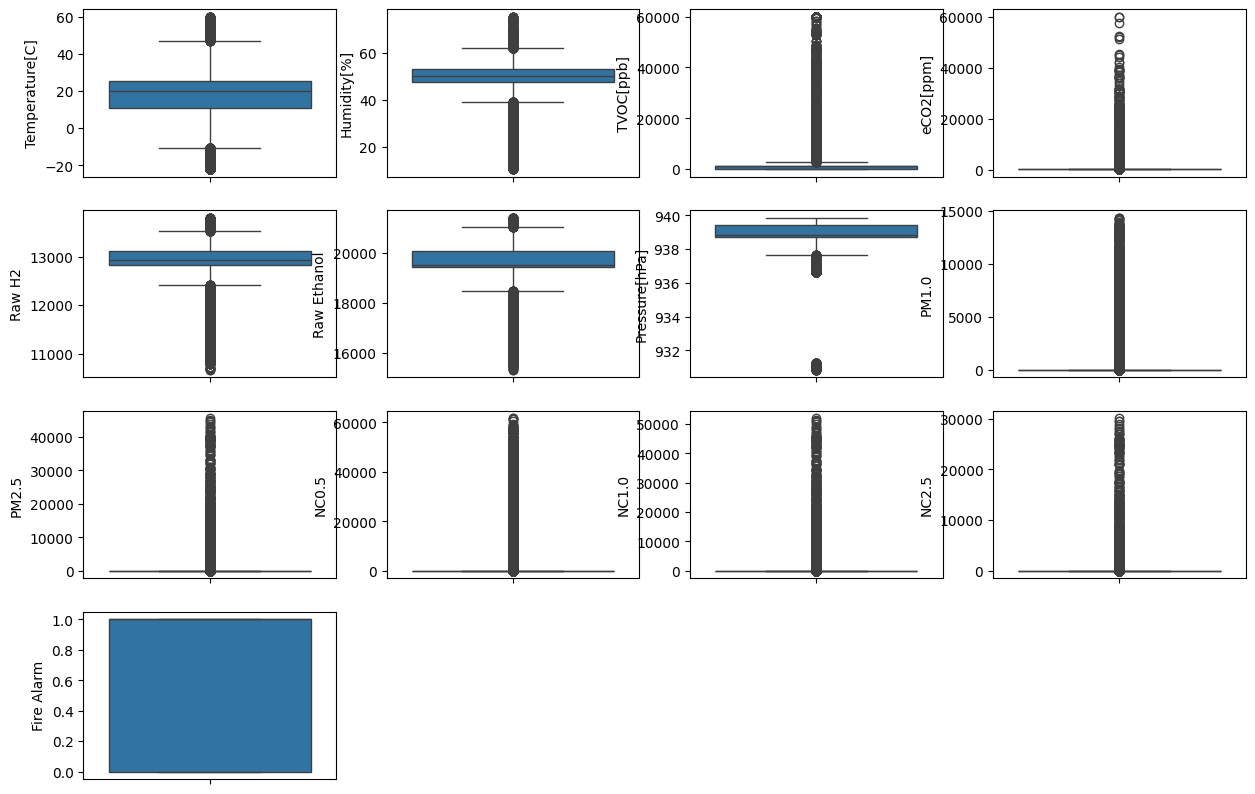

In [9]:
# Checking the Presence of Outliers
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15,10))
# List of Independent features
feature_list=ds.columns
# Running loop to create boxplots
for i in range(len(feature_list)):
  plt.subplot(4,4,i+1)
  sns.boxplot(ds[feature_list[i]])
plt.show()

**Treatment of Outliers**

In [10]:
# Dealing with Outliers(Calculate Q1,Q3 and IQR for all features)
Q1=ds.quantile(0.25)
Q3=ds.quantile(0.75)
IQR=Q3-Q1
print(IQR)


Temperature[C]      14.41525
Humidity[%]          5.71000
TVOC[ppb]         1059.00000
eCO2[ppm]           38.00000
Raw H2             279.00000
Raw Ethanol        643.00000
Pressure[hPa]        0.71800
PM1.0                0.81000
PM2.5                0.84000
NC0.5                5.60000
NC1.0                0.86500
NC2.5                0.01800
Fire Alarm           1.00000
dtype: float64


In [11]:
# Define a Function to handle outliers using np.clip
def handle_outliers(df,feature_list):
  lower_bound=Q1[feature_list]-1.5*IQR[feature_list]
  upper_bound=Q3[feature_list]+1.5*IQR[feature_list]
  # Replace values outside the bounds with the respective bounds
  df[feature_list]=np.clip(df[feature_list],lower_bound,upper_bound)
# Apply treatment to each numerical feature in dataset
for feature in feature_list:
  handle_outliers(ds,feature)

**Rechecking the Outliers**

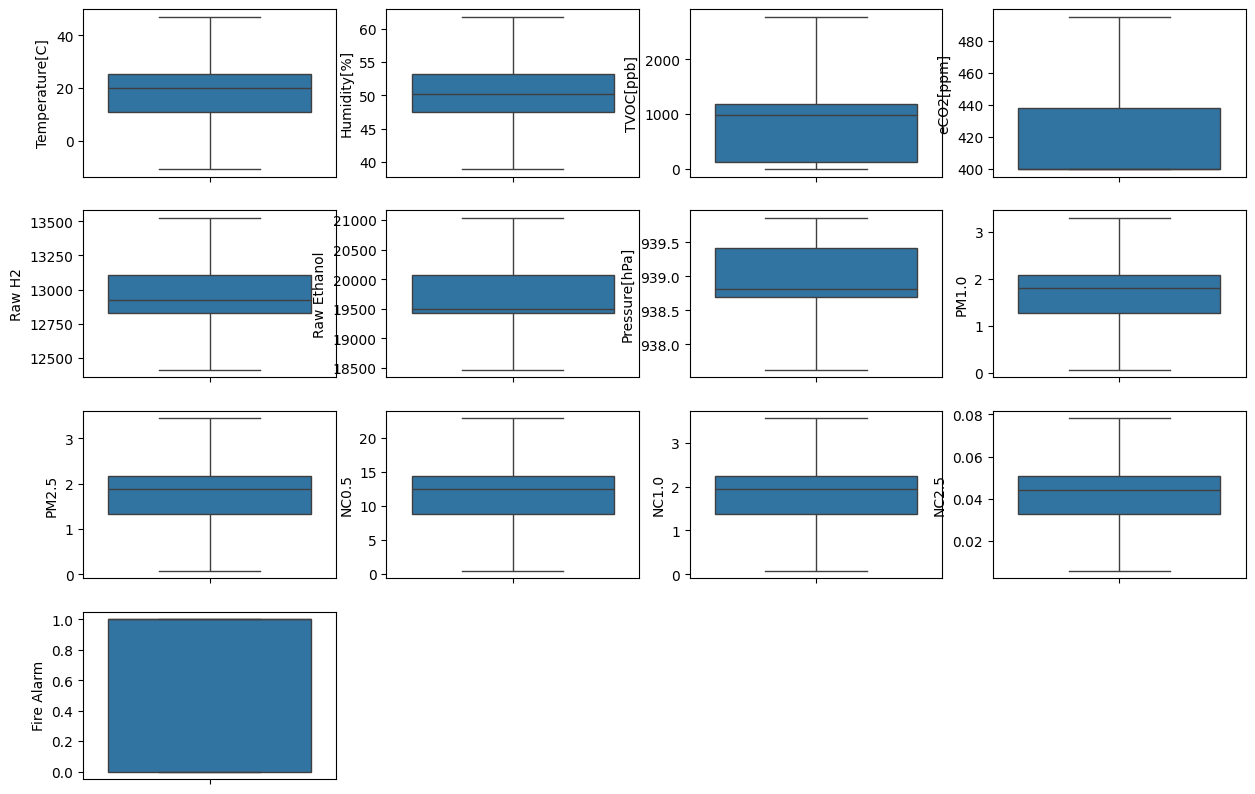

In [12]:
# Checking the Presence of Outliers
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15,10))
# List of Independent features
feature_list=ds.columns
# Running loop to create boxplots
for i in range(len(feature_list)):
  plt.subplot(4,4,i+1)
  sns.boxplot(ds[feature_list[i]])
plt.show()

In [13]:
# Distribution of Targeted Columns
print(ds['Fire Alarm'].value_counts())
print(" ")
print(ds['Fire Alarm'].value_counts(normalize=True)*100)

Fire Alarm
1    44757
0    17873
Name: count, dtype: int64
 
Fire Alarm
1    71.462558
0    28.537442
Name: proportion, dtype: float64


**Splitting Dataset in the form of training and testing**

In [14]:
from sklearn.model_selection import train_test_split
X=ds.drop('Fire Alarm',axis=1)
y=ds['Fire Alarm']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [15]:
X_train.shape, X_test.shape

((50104, 12), (12526, 12))

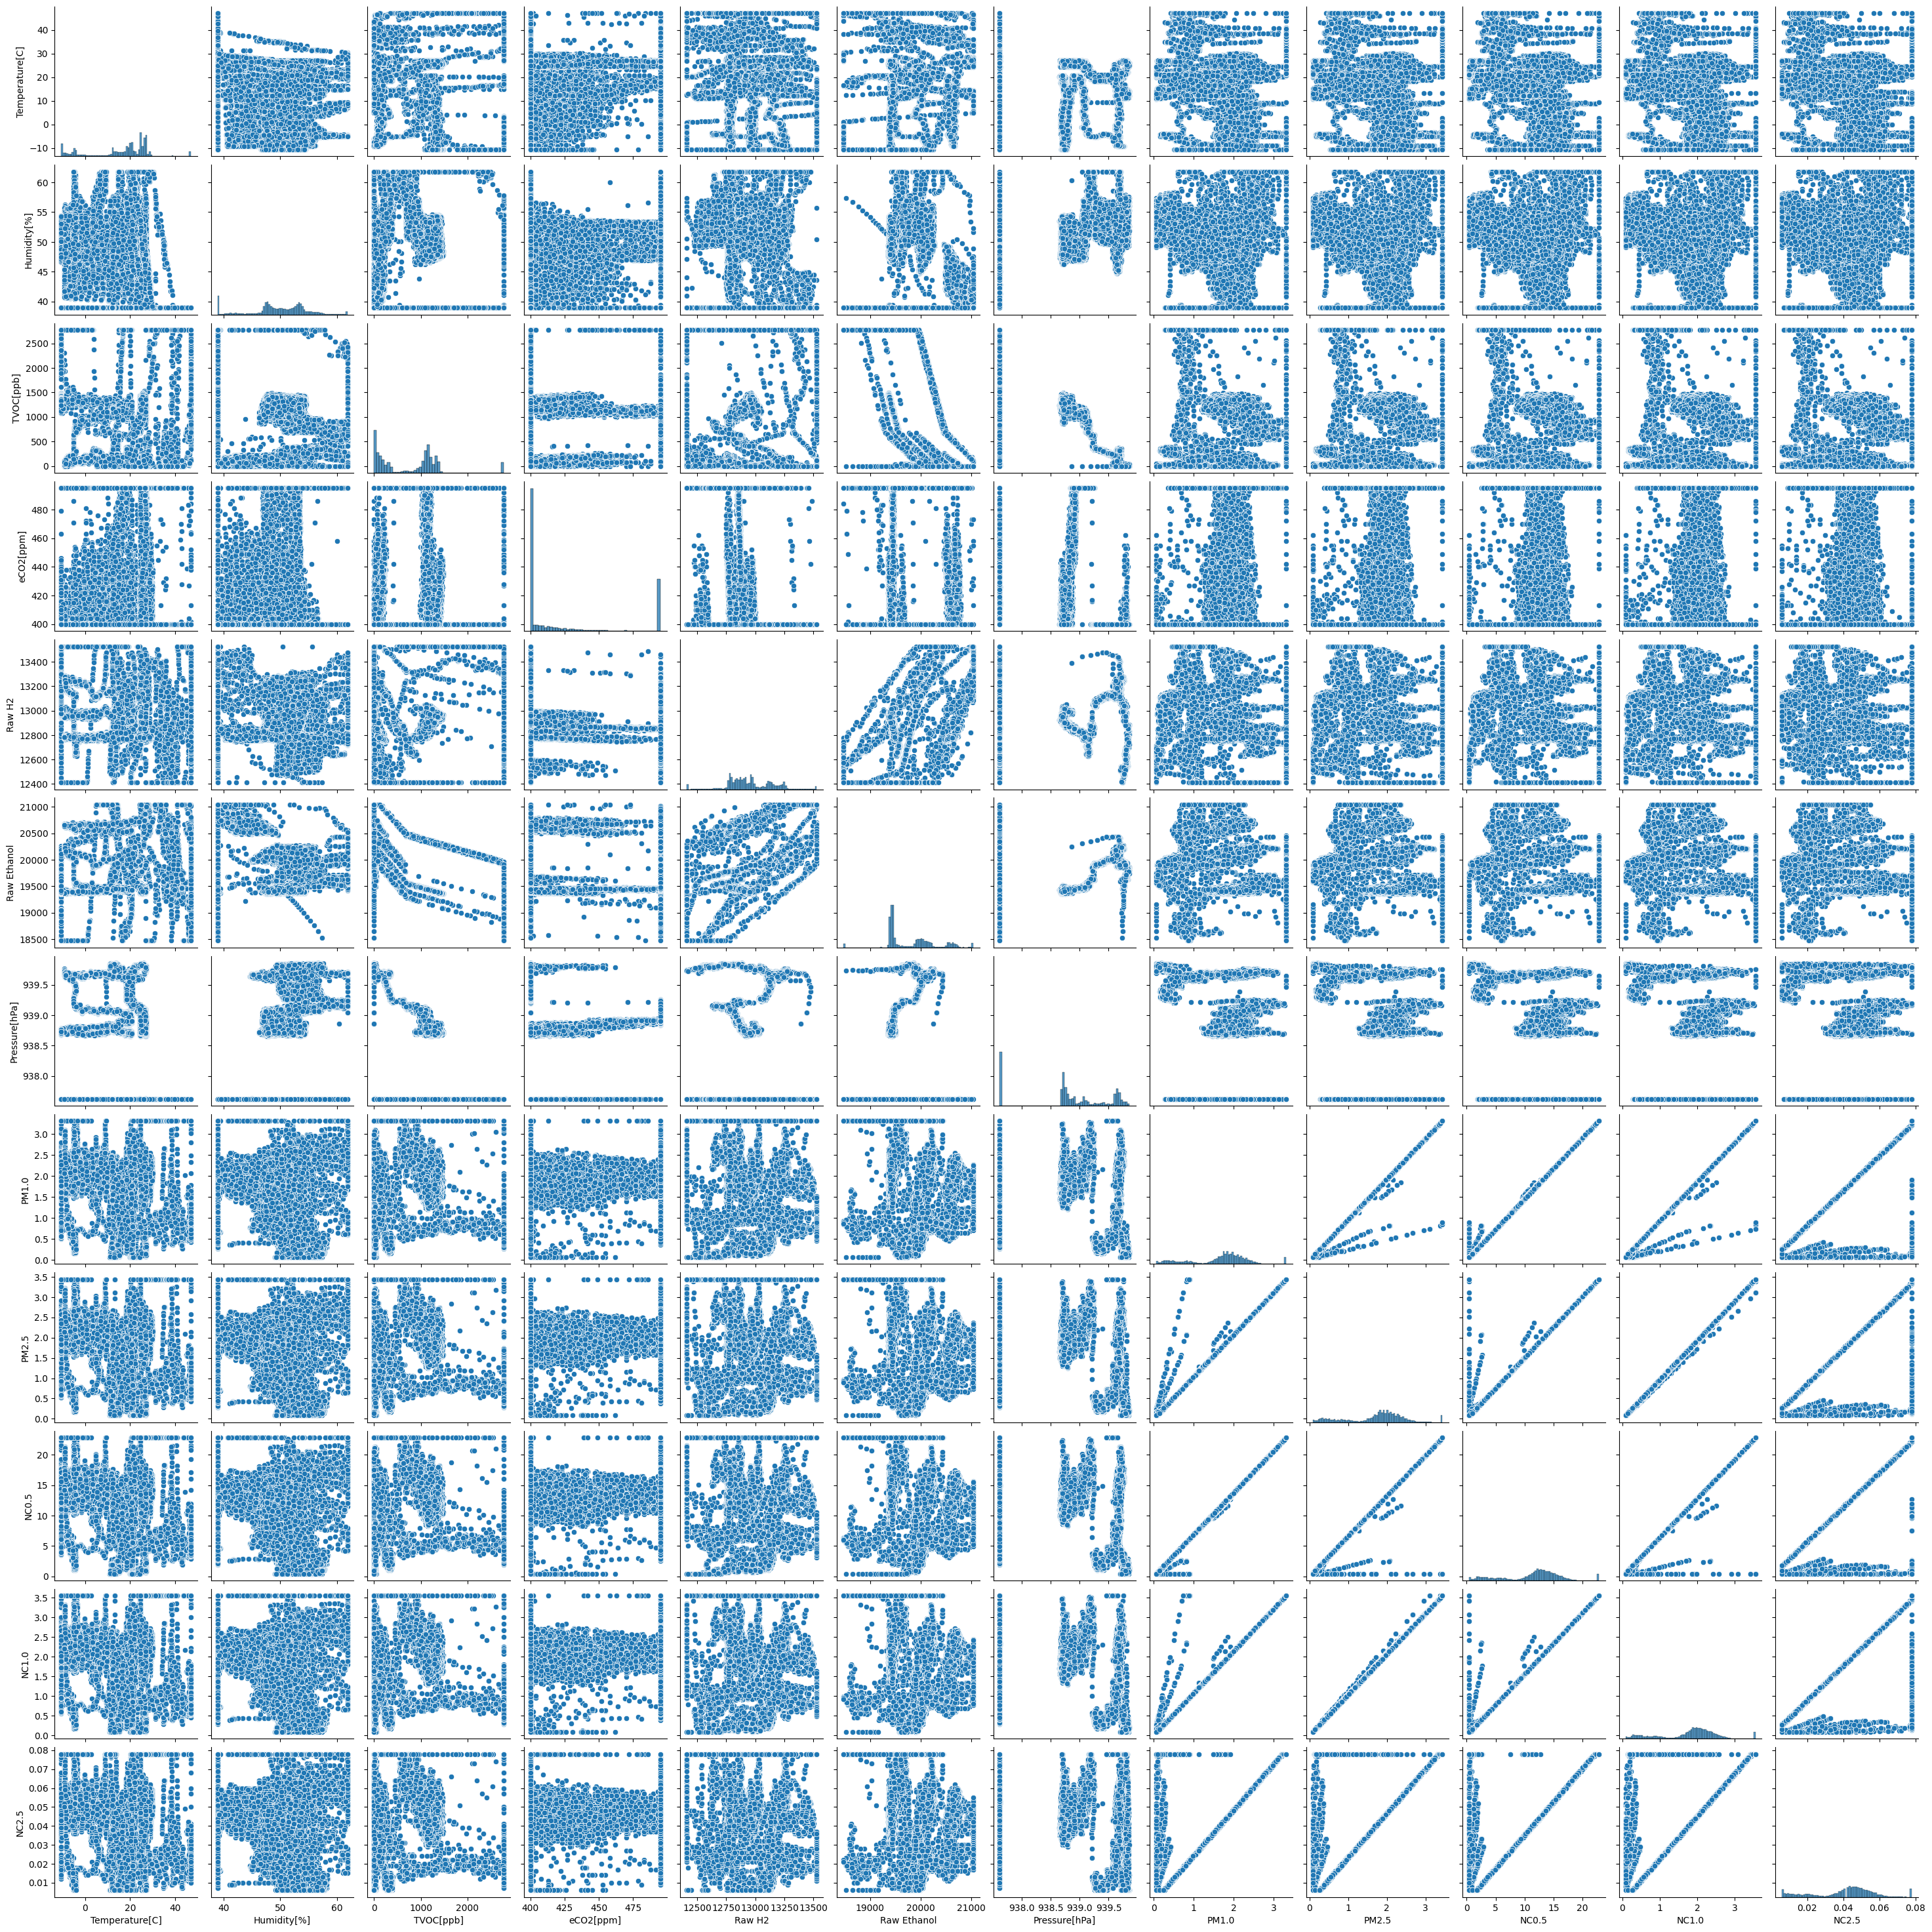

In [16]:
sns.pairplot(X_train);

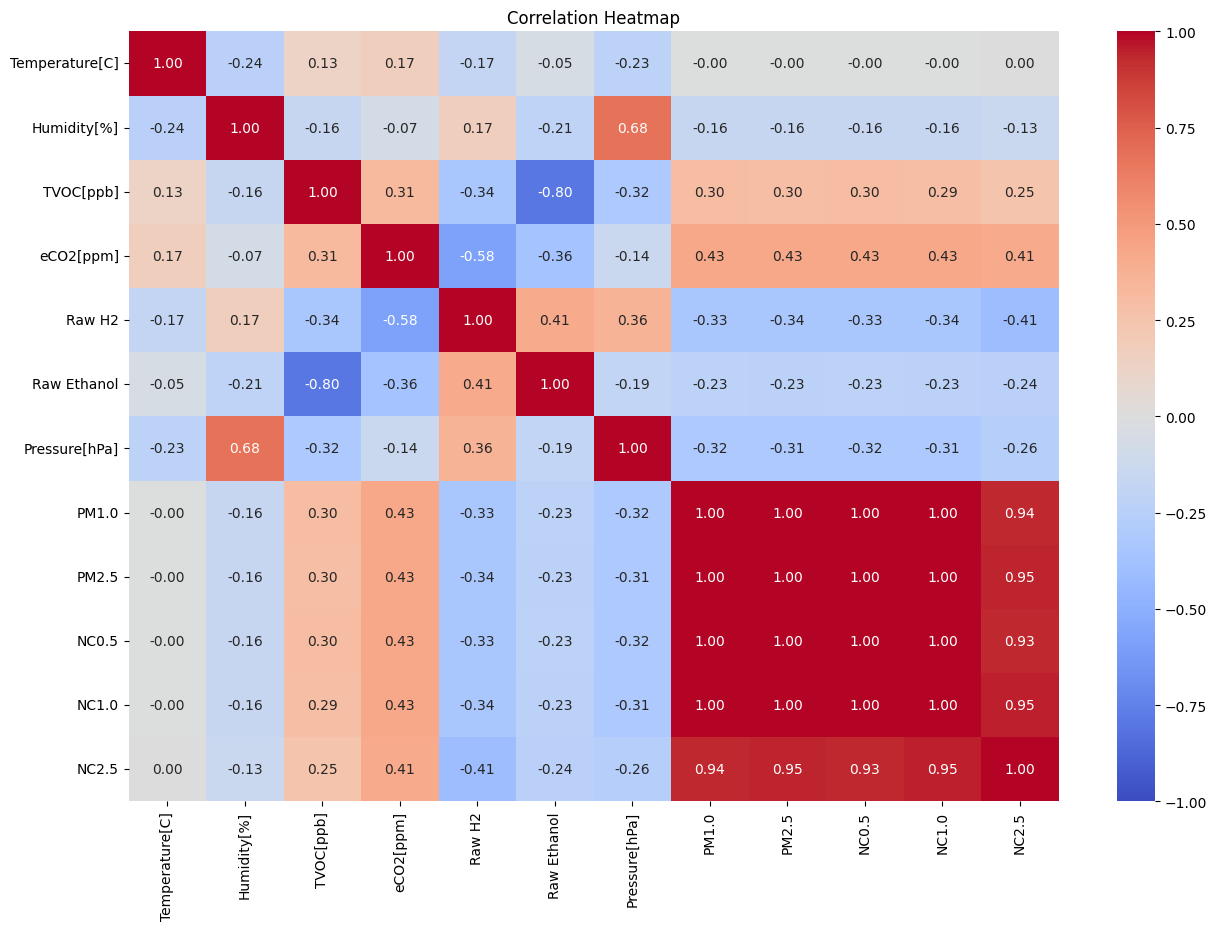

In [17]:
# Visualize correlation between numerical features
plt.figure(figsize=(15,10))
sns.heatmap(X_train.corr(),annot=True,cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

**Multicollinearity treatmet using VIF**

In [18]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif=pd.DataFrame()
vif['Features']=X_train.columns
vif['VIF']=[variance_inflation_factor(X_train.values,i) for i in range(X_train.shape[1])]
# Display VIF Values
print("VIF Values:")
print(vif.sort_values(by='VIF',ascending=False))

VIF Values:
          Features            VIF
7            PM1.0  260058.531209
8            PM2.5  179720.376102
10           NC1.0  153229.769566
9            NC0.5  152556.720582
6    Pressure[hPa]   15424.376005
4           Raw H2    9185.355582
5      Raw Ethanol    7664.144028
3        eCO2[ppm]     229.586751
1      Humidity[%]     186.183660
11           NC2.5      85.331261
2        TVOC[ppb]       9.688503
0   Temperature[C]       2.759453


In [19]:
# Set a threshold for maximum VIF value.
max_vif=5
# Initializing the list of removed values
removed_variables=[]
# Initializing the flag that checks for the value which exceeds the threshold value.
remove_flag=True
while remove_flag:
  vif=pd.DataFrame()
  vif['Features']=X_train.columns
  vif['VIF']=[variance_inflation_factor(X_train.values,i) for i in range(X_train.shape[1])]
  # Find the variable with highest VIF
  max_vif_variable=vif.loc[vif['VIF'].idxmax()]
  if max_vif_variable['VIF']>max_vif:
    # Remove the variable with highest vif from x_train
      removed_variable=max_vif_variable['Features']
      X_train=X_train.drop(removed_variable,axis=1)
      # Add the variable to the list of removed variables
      removed_variables.append(removed_variable)
      print(f"Removed Variable with high vif: {removed_variable}(VIF={max_vif_variable['VIF']})")
  else:
    # If no variable exceeds the threshold, set the flag to false to exit the loop.
    remove_flag=False
# print the final set of variables
print("Final Variable after VIF removal:", X_train.columns)

Removed Variable with high vif: PM1.0(VIF=260058.5312086061)
Removed Variable with high vif: PM2.5(VIF=172667.1130141875)
Removed Variable with high vif: Pressure[hPa](VIF=15280.655933898723)
Removed Variable with high vif: Raw H2(VIF=5735.567254577977)
Removed Variable with high vif: NC1.0(VIF=962.2708819468726)
Removed Variable with high vif: Raw Ethanol(VIF=190.34853083590565)
Removed Variable with high vif: eCO2[ppm](VIF=92.37688337342558)
Removed Variable with high vif: NC2.5(VIF=52.38873184507269)
Removed Variable with high vif: Humidity[%](VIF=6.571275405850856)
Final Variable after VIF removal: Index(['Temperature[C]', 'TVOC[ppb]', 'NC0.5'], dtype='object')


In [20]:
# Drop corressponding columns from X_test
X_test=X_test.drop(columns=removed_variables,errors='ignore')

In [21]:
X_train.shape, X_test.shape

((50104, 3), (12526, 3))

In [22]:
X_train.head()

Temperature[C]  TVOC[ppb]  NC0.5
7081           -5.087      222.0   3.00
49171          24.310     1182.0  13.94
14084          17.312     1145.0  12.44
31206          20.100      191.0   5.58
30582          21.710       35.0  15.26

In [23]:
from sklearn.preprocessing import StandardScaler
# Initialize the StandardScaler
scaler=StandardScaler()
# Fit and transform on X_train
X_train_scaled=pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)
# Transform X_test using the Same Scaler
X_test_scaled=pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)


**Model Building**

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report
# Initialize Logisitic Regression model
LM=LogisticRegression(random_state=123)
# Train model on scaled training data
LM.fit(X_train_scaled,y_train)
# Prediction on scaled training data
y_train_pred=LM.predict(X_train_scaled)
# Prediction on scaled testing data
y_test_pred=LM.predict(X_test_scaled)
# Evalute confusion matrix for training data
cm_train=confusion_matrix(y_train,y_train_pred)
# Evalute confusion matrix for testing data
cm_test=confusion_matrix(y_test,y_test_pred)

In [25]:
# Visualize confusion matrices side by side using subplot
plt.figure(figsize=(10,5))

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

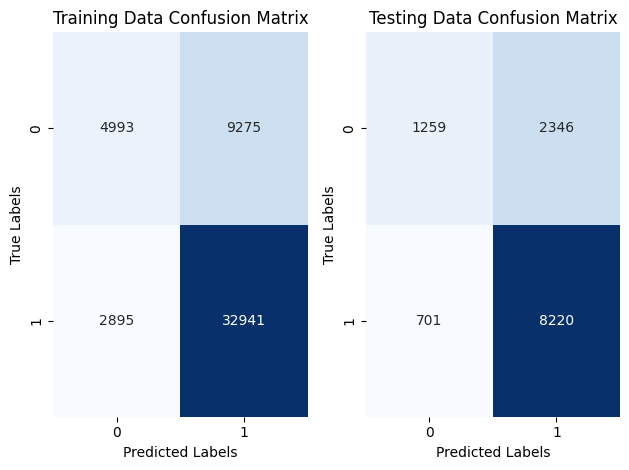

In [26]:
# Subplot for Training Data
plt.subplot(1,2,1)
sns.heatmap(cm_train,annot=True,fmt='d',cmap='Blues',cbar=False)
plt.title('Training Data Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

#Subplot for Testing Data
plt.subplot(1,2,2)
sns.heatmap(cm_test,annot=True,fmt='d',cmap='Blues',cbar=False)
plt.title('Testing Data Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.tight_layout()
plt.show()

In [27]:
# Classification report on training data
cr_train=classification_report(y_train,y_train_pred)
print("Classification Report on Training Data:\n",cr_train)
# Classification report on testing data
cr_test=classification_report(y_test,y_test_pred)
print("Classification Report on Testing Data:\n",cr_test)

Classification Report on Training Data:
               precision    recall  f1-score   support

           0       0.63      0.35      0.45     14268
           1       0.78      0.92      0.84     35836

    accuracy                           0.76     50104
   macro avg       0.71      0.63      0.65     50104
weighted avg       0.74      0.76      0.73     50104

Classification Report on Testing Data:
               precision    recall  f1-score   support

           0       0.64      0.35      0.45      3605
           1       0.78      0.92      0.84      8921

    accuracy                           0.76     12526
   macro avg       0.71      0.64      0.65     12526
weighted avg       0.74      0.76      0.73     12526



In [28]:
import statsmodels.api as sm
# Add a constant column to features
X_train_sm=sm.add_constant(X_train_scaled)
X_test_sm=sm.add_constant(X_test_scaled)
# Aligning the indices of y Variable
y_train_sm=y_train.reset_index(drop=True)
y_test_sm=y_test.reset_index(drop=True)
# Fit Logistic regression model using statsmodels
logit_model=sm.Logit(y_train_sm,X_train_sm).fit()
# Print the summary of the Logistic Regression model
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.524908
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             Fire Alarm   No. Observations:                50104
Model:                          Logit   Df Residuals:                    50100
Method:                           MLE   Df Model:                            3
Date:                Sun, 17 Nov 2024   Pseudo R-squ.:                  0.1213
Time:                        12:21:27   Log-Likelihood:                -26300.
converged:                       True   LL-Null:                       -29932.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.0973      0.011     95.838      0.000       1.075       1.120
Temperature[C]   

In [30]:
print("Coefficeints from sklearn",LM.coef_)
print("Intercept from statsmodels",LM.intercept_)

Coefficeints from sklearn [[-0.56505317  0.60940988  0.43948939]]
Intercept from statsmodels [1.09754209]


In [32]:
# Make predictions on the scaled training data (Probabilities)
y_train_pred_prob=logit_model.predict(X_train_sm)
y_train_pred_class=(y_train_pred_prob>=0.5).astype(int)
# Make predictions on the scaled testing data (Probabilities)
y_test_pred_prob=logit_model.predict(X_test_sm)
y_test_pred_class=(y_test_pred_prob>=0.5).astype(int)
# Classification report for train data
print(classification_report(y_train_sm,y_train_pred_class))
print(" ")
# Classification report for test data
print(classification_report(y_test_sm,y_test_pred_class))

              precision    recall  f1-score   support

           0       0.63      0.35      0.45     14268
           1       0.78      0.92      0.84     35836

    accuracy                           0.76     50104
   macro avg       0.71      0.63      0.65     50104
weighted avg       0.74      0.76      0.73     50104

 
              precision    recall  f1-score   support

           0       0.64      0.35      0.45      3605
           1       0.78      0.92      0.84      8921

    accuracy                           0.76     12526
   macro avg       0.71      0.64      0.65     12526
weighted avg       0.74      0.76      0.73     12526

